In [1]:
import matplotlib
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from utility import *
from models import *

from os import listdir
from os.path import isfile, join
import numpy as np
import math

import torch.optim as optim

# Define from where to load the files 

In [2]:
polycube_path = "/Users/davidcleres/DeepShape/Polycubing-Automated/Generated-Cars/"
polycube_files = [f for f in listdir(polycube_path) if isfile(join(polycube_path, f))]

voxelized_mesh_path = "/Users/davidcleres/DeepShape/Polycubing-Automated/voxelizedMeshes/"
voxelized_mesh_files = [f for f in listdir(voxelized_mesh_path) if isfile(join(voxelized_mesh_path, f))]

voxelizedFiles = []
polycubedFiles = []

for f in voxelized_mesh_files: 
    if f[-13:] == "voxelized.txt":
        voxelizedFiles = np.hstack((voxelizedFiles, f))
    
for f in polycube_files:
    if f[-14:] == "finalCubes.txt":
        polycubedFiles = np.hstack((polycubedFiles, f))

# Load the data

In [3]:
grid_size = 32
voxelized_train_input, polycube_target=loadData(grid_size, polycube_path, voxelized_mesh_path, voxelizedFiles, polycubedFiles, loadFromScratch=False)

# Build a training and validation set 

In [4]:
batch_size = 10 
validation_size=50
preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(voxelized_train_input, polycube_target, validation_size, False, False)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train)
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation)
preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:,0,0,0,0]) 
Nvalidation = len(preprocessed_input_validation[:,0,0,0,0])
image_size = 32

train_input = np.array(preprocessed_input_train.view(Ntrain, 1,image_size, image_size, image_size))
validation_input = np.array(preprocessed_input_validation.view(Nvalidation, 1,image_size, image_size, image_size))

labels_train = np.array(preprocessed_input_train_target.view(Ntrain, 1, image_size, image_size, image_size))
labels_validation = np.array(preprocessed_input_validation_target.view(Nvalidation, 1,image_size, image_size, image_size))

# Create the target 
Find the middle of the cube and the distance to the x, y and z boundaries

In [5]:
labels_train_cube_coords = np.zeros((len(train_input[:,0,0,0,0]), 1, 9))
for i in range (len(train_input[:,0,0,0,0])):
    #solution 1 - the loss is calculed based on the 9 labels 
    delta_x_left, delta_x_right, center_x, delta_y_left, delta_y_right, center_y, delta_z_left, delta_z_right, center_z = find_center_and_delta(labels_train[i, 0, :, :, :], grid_size=32)
    labels_train_cube_coords[i,0,0] = delta_x_left
    labels_train_cube_coords[i,0,1] = delta_x_right
    labels_train_cube_coords[i,0,2] = center_x
    labels_train_cube_coords[i,0,3] = delta_y_left
    labels_train_cube_coords[i,0,4] = delta_y_right
    labels_train_cube_coords[i,0,5] = center_y
    labels_train_cube_coords[i,0,6] = delta_z_left
    labels_train_cube_coords[i,0,7] = delta_z_right
    labels_train_cube_coords[i,0,8] = center_z
    
labels_validation_cube_coords = np.zeros((len(labels_validation[:,0,0,0,0]), 1, 9))
for i in range (len((validation_input[:,0,0,0,0]))):
    #solution 1 - the loss is calculed based on the 9 labels 
    delta_x_left, delta_x_right, center_x, delta_y_left, delta_y_right, center_y, delta_z_left, delta_z_right, center_z = find_center_and_delta(labels_train[i, 0, :, :, :], grid_size=32)
    labels_validation_cube_coords[i, 0,0] = delta_x_left
    labels_validation_cube_coords[i, 0,1] = delta_x_right
    labels_validation_cube_coords[i, 0,2] = center_x
    labels_validation_cube_coords[i, 0,3] = delta_y_left
    labels_validation_cube_coords[i, 0,4] = delta_y_right
    labels_validation_cube_coords[i, 0,5] = center_y
    labels_validation_cube_coords[i, 0,6] = delta_z_left
    labels_validation_cube_coords[i, 0,7] = delta_z_right
    labels_validation_cube_coords[i, 0,8] = center_z
    
    
labels_validation_cube_coords = torch.from_numpy(labels_validation_cube_coords)
labels_train_cube_coords = torch.from_numpy(labels_train_cube_coords)
train_input = torch.from_numpy(train_input)
validation_input = torch.from_numpy(validation_input)

print('train_input', train_input.shape)
print('labels_train_cube_coords', labels_train_cube_coords.shape)

print('validation_input', validation_input.shape)
print('labels_validation_cube_coords', labels_validation_cube_coords.shape)

    
    #solution 2 - the loss is calculated from the cube generated thanks to the learned coordinates 
    #output = build_cube(delta_x_left, delta_x_right, center_x, delta_y_left, delta_y_right, center_y, delta_z_left, delta_z_right, center_z, grid_size)
    

train_input torch.Size([550, 1, 32, 32, 32])
labels_train_cube_coords torch.Size([550, 1, 9])
validation_input torch.Size([50, 1, 32, 32, 32])
labels_validation_cube_coords torch.Size([50, 1, 9])


In [6]:
# Train network 
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

train_input = Variable(train_input).float()
validation_input = Variable(validation_input).float()

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train_cube_coords)  # keep long tensors
    validation_target = Variable(labels_validation_cube_coords, 
    uires_grad=False) # convert to float
    Noutputs = 18
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train_cube_coords)  # keep long tensors
    validation_target = Variable(labels_validation_cube_coords, requires_grad=False) # convert to float
    Noutputs = 18
    
else:
    train_target = Variable(labels_train_cube_coords, requires_grad=False).float() # convert to float
    validation_target = Variable(labels_validation_cube_coords, requires_grad=False).float() # convert to float
    Noutputs = 9

Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 500
#seeds = list(range(15)) #Test 15 different seeds but always the seeds from 0 to 15 so that the weights are always initialized in a reproducible way
#Nrep = len(seeds)
Nrep = 1

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    #print('Repetition', seeds[i_rep])
    #torch.manual_seed(seeds[i_rep])
    
    #model = conv2DNet_1(Nchannels, Nsamples_100, Noutputs) #from litterature EEG-Net coorected
    model = conv2DNet_2(Noutputs)  #from Temporal - Spatial; 4 Filters Model - Best performing model with accuracy 0.83 in average on the validation set
    #model = conv2DNet_3(Noutputs) #from Temporal - Spatial; 64 Filters Model
    #model = conv2DNet_4(Noutputs) #from Temporal - Spatial; 128 Filters Model
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True) #Reduces the learning rate if it did not decreased by more than 10^-4 in 10 steps

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
                batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))
            else:
                batch_loss = criterion(output.view(bsize_eff*Noutputs), train_target.narrow(0, b_start, bsize_eff))
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        #scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors_delta(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors_delta(model, validation_input, validation_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain*Noutputs-nb_train_errs)/(Ntrain*Noutputs)))
        print("\t Validation accuracy ",(100*(Nvalidation*Noutputs-nb_validation_errs)/(Nvalidation*Noutputs)))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Epoch Number :  0
	 Training accuracy:  98.24242424242425
	 Validation accuracy  80.22222222222223
	 Epoch Loss  33754.07421875
Epoch Number :  1
	 Training accuracy:  98.28282828282828
	 Validation accuracy  80.66666666666667
	 Epoch Loss  20435.40234375
Epoch Number :  2
	 Training accuracy:  98.20202020202021
	 Validation accuracy  80.22222222222223
	 Epoch Loss  17527.751953125
Epoch Number :  3
	 Training accuracy:  98.20202020202021
	 Validation accuracy  80.0
	 Epoch Loss  26744.4453125
Epoch Number :  4
	 Training accuracy:  98.24242424242425
	 Validation accuracy  80.0
	 Epoch Loss  24280.392578125
Epoch Number :  5
	 Training accuracy:  98.20202020202021
	 Validation accuracy  80.0
	 Epoch Loss  15553.021484375
Epoch Number :  6
	 Training accuracy:  98.28282828282828
	 Validation accuracy  80.22222222222223
	 Epoch Loss  30318.640625
Epoch Number :  7
	 Training accuracy:  98.20202020202021
	 Validation accuracy  80.0
	 Epoch Loss  19800.548828125
Epoch Number :  8
	 Trainin

Epoch Number :  64
	 Training accuracy:  98.70707070707071
	 Validation accuracy  83.33333333333333
	 Epoch Loss  314.4631652832031
Epoch Number :  65
	 Training accuracy:  98.56565656565657
	 Validation accuracy  82.44444444444444
	 Epoch Loss  311.6839599609375
Epoch Number :  66
	 Training accuracy:  98.44444444444444
	 Validation accuracy  83.33333333333333
	 Epoch Loss  312.5277404785156
Epoch Number :  67
	 Training accuracy:  98.62626262626263
	 Validation accuracy  82.88888888888889
	 Epoch Loss  330.8912048339844
Epoch Number :  68
	 Training accuracy:  98.54545454545455
	 Validation accuracy  82.0
	 Epoch Loss  425.1662292480469
Epoch Number :  69
	 Training accuracy:  98.74747474747475
	 Validation accuracy  84.0
	 Epoch Loss  286.9247741699219
Epoch Number :  70
	 Training accuracy:  98.72727272727273
	 Validation accuracy  82.44444444444444
	 Epoch Loss  286.9089660644531
Epoch Number :  71
	 Training accuracy:  98.54545454545455
	 Validation accuracy  83.11111111111111
	 

Epoch Number :  127
	 Training accuracy:  99.07070707070707
	 Validation accuracy  85.77777777777777
	 Epoch Loss  81.1088638305664
Epoch Number :  128
	 Training accuracy:  99.0909090909091
	 Validation accuracy  85.33333333333333
	 Epoch Loss  81.7378921508789
Epoch Number :  129
	 Training accuracy:  98.84848484848484
	 Validation accuracy  84.88888888888889
	 Epoch Loss  107.31300354003906
Epoch Number :  130
	 Training accuracy:  99.05050505050505
	 Validation accuracy  84.0
	 Epoch Loss  71.89588165283203
Epoch Number :  131
	 Training accuracy:  99.11111111111111
	 Validation accuracy  85.33333333333333
	 Epoch Loss  85.82560729980469
Epoch Number :  132
	 Training accuracy:  99.01010101010101
	 Validation accuracy  84.44444444444444
	 Epoch Loss  74.1005859375
Epoch Number :  133
	 Training accuracy:  99.35353535353535
	 Validation accuracy  83.77777777777777
	 Epoch Loss  88.41265869140625
Epoch Number :  134
	 Training accuracy:  99.25252525252525
	 Validation accuracy  83.55

Epoch Number :  190
	 Training accuracy:  99.17171717171718
	 Validation accuracy  83.77777777777777
	 Epoch Loss  141.29843139648438
Epoch Number :  191
	 Training accuracy:  99.11111111111111
	 Validation accuracy  83.55555555555556
	 Epoch Loss  120.933349609375
Epoch Number :  192
	 Training accuracy:  98.92929292929293
	 Validation accuracy  84.22222222222223
	 Epoch Loss  157.2489471435547
Epoch Number :  193
	 Training accuracy:  98.92929292929293
	 Validation accuracy  84.44444444444444
	 Epoch Loss  154.22056579589844
Epoch Number :  194
	 Training accuracy:  98.82828282828282
	 Validation accuracy  84.66666666666667
	 Epoch Loss  158.089111328125
Epoch Number :  195
	 Training accuracy:  98.92929292929293
	 Validation accuracy  83.33333333333333
	 Epoch Loss  148.28475952148438
Epoch Number :  196
	 Training accuracy:  98.86868686868686
	 Validation accuracy  84.44444444444444
	 Epoch Loss  192.19244384765625
Epoch Number :  197
	 Training accuracy:  98.9090909090909
	 Valida

Epoch Number :  253
	 Training accuracy:  98.5050505050505
	 Validation accuracy  84.66666666666667
	 Epoch Loss  186.09986877441406
Epoch Number :  254
	 Training accuracy:  98.60606060606061
	 Validation accuracy  81.33333333333333
	 Epoch Loss  213.1182861328125
Epoch Number :  255
	 Training accuracy:  98.54545454545455
	 Validation accuracy  83.11111111111111
	 Epoch Loss  271.652587890625
Epoch Number :  256
	 Training accuracy:  98.94949494949495
	 Validation accuracy  82.66666666666667
	 Epoch Loss  226.54669189453125
Epoch Number :  257
	 Training accuracy:  98.68686868686869
	 Validation accuracy  84.0
	 Epoch Loss  206.49447631835938
Epoch Number :  258
	 Training accuracy:  98.70707070707071
	 Validation accuracy  83.11111111111111
	 Epoch Loss  271.9506530761719
Epoch Number :  259
	 Training accuracy:  98.58585858585859
	 Validation accuracy  83.55555555555556
	 Epoch Loss  334.603271484375
Epoch Number :  260
	 Training accuracy:  98.60606060606061
	 Validation accuracy 

Epoch Number :  316
	 Training accuracy:  98.92929292929293
	 Validation accuracy  82.44444444444444
	 Epoch Loss  173.42672729492188
Epoch Number :  317
	 Training accuracy:  98.36363636363636
	 Validation accuracy  82.22222222222223
	 Epoch Loss  205.9748077392578
Epoch Number :  318
	 Training accuracy:  98.74747474747475
	 Validation accuracy  83.77777777777777
	 Epoch Loss  213.65208435058594
Epoch Number :  319
	 Training accuracy:  98.70707070707071
	 Validation accuracy  83.33333333333333
	 Epoch Loss  178.0428924560547
Epoch Number :  320
	 Training accuracy:  98.82828282828282
	 Validation accuracy  84.44444444444444
	 Epoch Loss  210.1643829345703
Epoch Number :  321
	 Training accuracy:  98.44444444444444
	 Validation accuracy  82.66666666666667
	 Epoch Loss  241.74856567382812
Epoch Number :  322
	 Training accuracy:  98.74747474747475
	 Validation accuracy  83.33333333333333
	 Epoch Loss  232.1937713623047
Epoch Number :  323
	 Training accuracy:  98.68686868686869
	 Vali

Epoch Number :  378
	 Training accuracy:  98.96969696969697
	 Validation accuracy  86.22222222222223
	 Epoch Loss  63.84920120239258
Epoch Number :  379
	 Training accuracy:  98.60606060606061
	 Validation accuracy  84.22222222222223
	 Epoch Loss  76.99207305908203
Epoch Number :  380
	 Training accuracy:  98.88888888888889
	 Validation accuracy  84.44444444444444
	 Epoch Loss  71.00199127197266
Epoch Number :  381
	 Training accuracy:  98.64646464646465
	 Validation accuracy  82.66666666666667
	 Epoch Loss  70.27627563476562
Epoch Number :  382
	 Training accuracy:  98.60606060606061
	 Validation accuracy  83.11111111111111
	 Epoch Loss  136.13980102539062
Epoch Number :  383
	 Training accuracy:  98.44444444444444
	 Validation accuracy  81.77777777777777
	 Epoch Loss  220.52955627441406
Epoch Number :  384
	 Training accuracy:  98.76767676767676
	 Validation accuracy  82.44444444444444
	 Epoch Loss  165.1508026123047
Epoch Number :  385
	 Training accuracy:  98.72727272727273
	 Valid

Epoch Number :  441
	 Training accuracy:  98.38383838383838
	 Validation accuracy  81.77777777777777
	 Epoch Loss  546.4263916015625
Epoch Number :  442
	 Training accuracy:  98.42424242424242
	 Validation accuracy  81.77777777777777
	 Epoch Loss  485.7121887207031
Epoch Number :  443
	 Training accuracy:  98.44444444444444
	 Validation accuracy  82.88888888888889
	 Epoch Loss  495.37347412109375
Epoch Number :  444
	 Training accuracy:  98.42424242424242
	 Validation accuracy  81.33333333333333
	 Epoch Loss  461.4933166503906
Epoch Number :  445
	 Training accuracy:  98.62626262626263
	 Validation accuracy  84.44444444444444
	 Epoch Loss  376.6488342285156
Epoch Number :  446
	 Training accuracy:  98.34343434343434
	 Validation accuracy  81.55555555555556
	 Epoch Loss  361.62823486328125
Epoch Number :  447
	 Training accuracy:  98.56565656565657
	 Validation accuracy  81.55555555555556
	 Epoch Loss  422.781005859375
Epoch Number :  448
	 Training accuracy:  98.60606060606061
	 Valida

# NETWORK SUMMARY & RESULTS

<IPython.core.display.Javascript object>


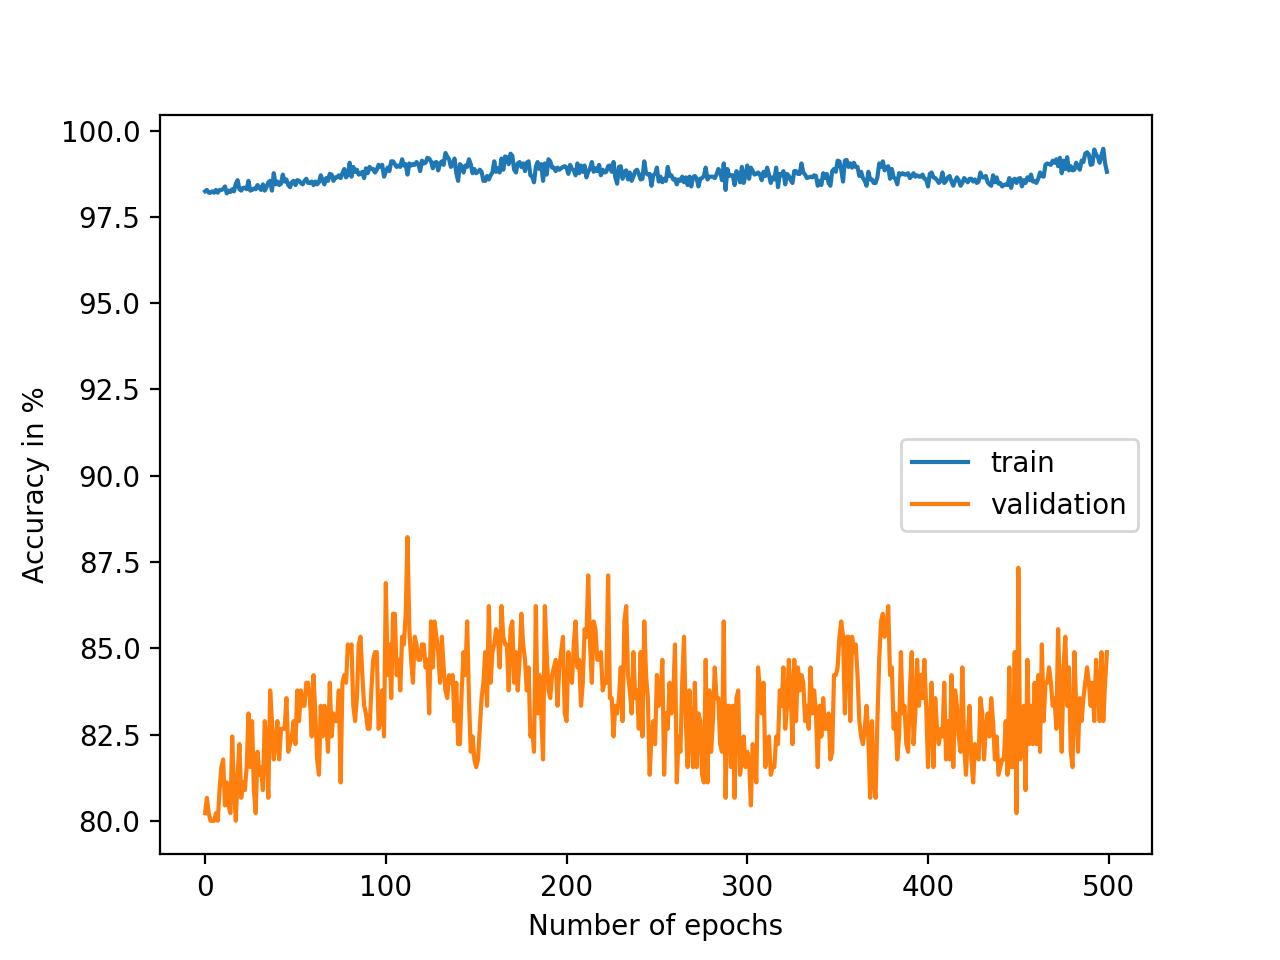

Training accuracy 98.80808
Validation accuracy 84.888885


In [8]:
train_accuracy = 100*(Ntrain*Noutputs-np.array(train_errors))/(Ntrain*Noutputs)
val_accuracy = 100*(Nvalidation*Noutputs-np.array(validation_errors))/(Nvalidation*Noutputs)
np.save('training_accuracy_Adamax', train_accuracy)
np.save('validation_accuracy_Adamax', val_accuracy)

epoch = list(range(Nepochs))
plt.plot(epoch, train_accuracy.reshape(Nepochs))
plt.plot(epoch, val_accuracy.reshape(Nepochs))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation'])
plt.show()

print("Training accuracy", train_accuracy[0, -1])
print("Validation accuracy", val_accuracy[0, -1])

In [ ]:
output.round()

In [ ]:
train_target.narrow(0, b_start, bsize_eff)